# Route-level analysis

Reading whole routes and comparing them across all times of day.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from pathlib import Path
from statsmodels.nonparametric.smoothers_lowess import lowess


# Config
day = 170
sensitivity_factor = 1.0

in_dir = Path(f'../../export/{day}/{sensitivity_factor}/exportdata')
out_dir = Path(in_dir.parent / 'analysis/route_level')
out_dir.mkdir(parents=True, exist_ok=True)

tod_list = ['10am', '1pm', '4pm', '7pm']
colors = [
    'yellowgreen',
    'darkgoldenrod',
    'plum',
    'tab:blue',
]
default_type = 'shortest'
optimized_type = 'shaded'

palette = {
    f'{default_type} route': 'darkgrey',
    f'{optimized_type} route at {tod_list[0]}': colors[0],
    f'{optimized_type} route at {tod_list[1]}': colors[1],
    f'{optimized_type} route at {tod_list[2]}': colors[2],
    f'{optimized_type} route at {tod_list[3]}': colors[3],
}
palette_sl = {
    'long': 'black',
    'short': 'darkturquoise',
}

sns.set_theme(style='whitegrid')
sns.set_context('paper')

xlim = (-2, 102)
ylim = (-2, 102)
ylim_neg = (2, -102)

In [2]:
# Helper functions
def subfolder(out_dir, name):
    """Returns the respective folder path and creates subfolders in out_dir with timestamps if not existent already"""
    out_folder = out_dir / name
    out_folder.mkdir(exist_ok=True)
    return out_folder

def tod_format(tod):
    """Returns the formatted time of day string"""
    return tod[:-2] + ' ' + tod[-2:].upper()

In [3]:
# Read data
df = gpd.read_feather(in_dir / 'route_level_statistics.feather')
print(df.columns)
print('Total routes: ', len(df))

Index(['trip_id', 'route_type', 'sol_expo_10am', 'sol_expo_1pm',
       'sol_expo_4pm', 'sol_expo_7pm', 'sol_expo_diff_abs',
       'sol_expo_diff_rel', 'sol_expo_reduction', 'distance', 'len_diff_meter',
       'len_diff_rel', 'duration', 'dur_diff_sec', 'dur_diff_perc',
       'same_ratio', 'avoided_ratio', 'detour_ratio', 'geom', 'geom_diff',
       'geom_intersect'],
      dtype='object')
Total routes:  50025


In [4]:
# Statistics about route length differences
df_u0 = df[df['len_diff_rel'] < 0]
print(len(df_u0), len(df))
print(df_u0.value_counts('route_type'))

df_0 = df[df['len_diff_rel'] == 0.0]
print(len(df_0), len(df))
print(df_0.value_counts('route_type'))

df_o0 = df[df['len_diff_rel'] > 0]
print(len(df_o0), len(df))
print(df_o0.value_counts('route_type'))

0 50025
Series([], dtype: int64)
8542 50025
route_type
shaded route at 7pm     2383
shaded route at 10am    2108
shaded route at 4pm     2096
shaded route at 1pm     1955
dtype: int64
31478 50025
route_type
shaded route at 1pm     8050
shaded route at 4pm     7909
shaded route at 10am    7897
shaded route at 7pm     7622
dtype: int64


## LOWESS curves 

Describe the relationship between solar exposure reduction and relative length increase. For the LOWESS calculation, solar exposure is used as independent variable, while length increase is handled as dependent on solar exposure.

In [5]:
x_value = 'len_diff_rel'
x_val_label='Length increase [%]'

y_value = 'sol_expo_reduction'
y_val_label='Solar exposure reduction [%]'

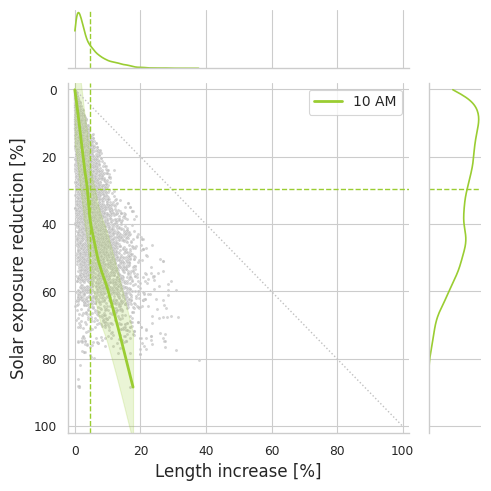

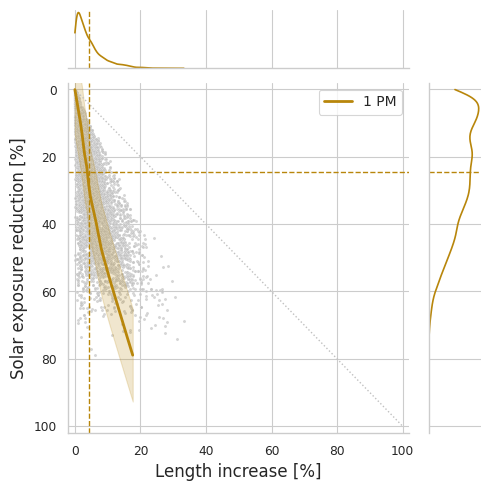

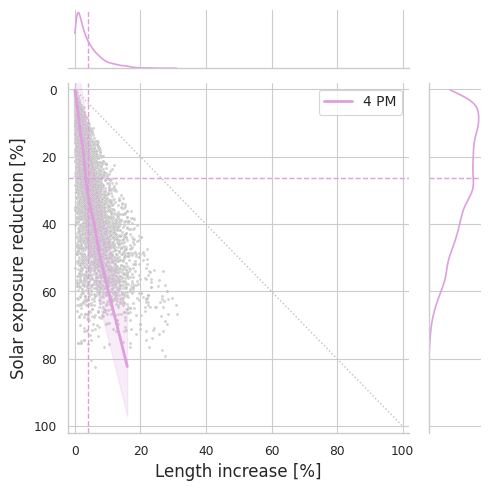

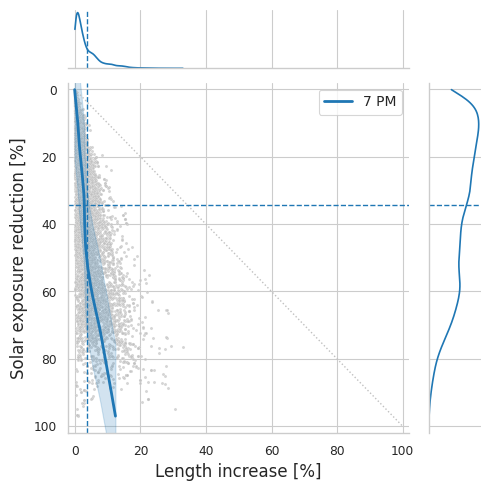

In [6]:
# Create LOWESS for each time of day
for tod, color in zip(tod_list, colors):
    # Filter data for this time of day
    dfex = df[df[f'sol_expo_{tod}'].notna()]
    dfex = dfex[dfex['len_diff_rel'] > 0]
    dfex_heal = dfex[dfex['route_type'] == f'{optimized_type} route at {tod}']

    # Calculate mean values
    xmean_heal = dfex_heal[x_value].mean()
    ymean_heal = dfex_heal[y_value].mean()

    # Create JointGrid instance and plot scatter and KDE
    g = sns.JointGrid(data=dfex_heal, x=x_value, y=y_value, ylim=ylim, xlim=xlim, height=5, marginal_ticks=False)
    g.ax_joint.plot((0, 100), (0, 100), color='silver', linestyle=':', linewidth=1)
    g.plot_joint(sns.scatterplot, alpha=0.66, s=5, color='silver')
    g.plot_marginals(sns.kdeplot, cut=0, color=color)

    # Compute LOWESS smoothing
    smoothed = lowess(exog=dfex_heal[y_value], endog=dfex_heal[x_value], frac=0.2)
    smoothed_x, smoothed_y = smoothed[:, 1], smoothed[:, 0]

    # Compute residuals and standard deviation
    residuals = dfex_heal[y_value] - np.interp(dfex_heal[x_value], smoothed_x, smoothed_y)
    std_dev = np.std(residuals)

    # Add mean values as reference lines
    g.refline(x=xmean_heal, y=ymean_heal, color=color, linewidth=1)

    # Add LOWESS curve
    g.ax_joint.plot(smoothed_x, smoothed_y, color=color, lw=2)

    # Add standard deviation bands
    g.ax_joint.fill_between(smoothed_x, smoothed_y - std_dev, smoothed_y + std_dev, color=color, alpha=0.2, label="±1 Std Dev")

    # Invert the y-axis
    g.ax_joint.invert_yaxis()

    # Set custom ticks
    g.ax_joint.set_xticks(np.arange(0, 101, 20))
    g.ax_joint.set_yticks(np.arange(0, 101, 20))

    # Set labels
    g.set_axis_labels(x_val_label, y_val_label, fontsize=12)

    # Add legend manually
    line = Line2D([0], [0], color=color, lw=2)
    g.ax_joint.legend([line], [tod_format(tod)], fontsize=10, loc='upper right')

    plt.tight_layout()
    plt.savefig(subfolder(out_dir, 'length_vs_sol_expo') / f'lowess_{tod}.png', dpi=300, bbox_inches='tight')
    plt.show()


10am: xmean=4.502599721413195, ymean=29.46072559199696
1pm: xmean=4.4013031055900615, ymean=24.53490310559006
4pm: xmean=4.122243014287521, ymean=26.302371981287145
7pm: xmean=3.596821044345316, ymean=34.2473812647599


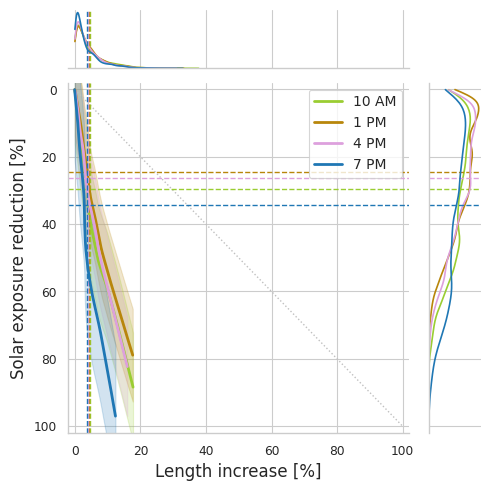

In [7]:
# Combine all LOWESS curves into one figure
g = sns.JointGrid(data=df, x=x_value, y=y_value, ylim=ylim, xlim=xlim, height=5, marginal_ticks=False)
g.ax_joint.plot((0, 100), (0, 100), color='silver', linestyle=':', linewidth=1)

for tod, color in zip(tod_list, colors):
    # Extract rows where sol_expo is not NaN
    dfex = df[df[f'sol_expo_{tod}'].notna()]
    dfex = dfex[dfex['len_diff_rel'] > 0]
    dfex_heal = dfex[dfex['route_type'] == f'{optimized_type} route at {tod}']

    # Calculate mean values
    xmean_heal = dfex_heal[x_value].mean()
    ymean_heal = dfex_heal[y_value].mean()
    print(f'{tod}: xmean={xmean_heal}, ymean={ymean_heal}')

    # Compute a LOWESS smoothing of the data
    smoothed = lowess(exog=dfex_heal[y_value], endog=dfex_heal[x_value], frac=0.2)
    smoothed_x, smoothed_y = smoothed[:, 1], smoothed[:, 0]

    # Compute residuals and standard deviation
    residuals = dfex_heal[y_value] - np.interp(dfex_heal[x_value], smoothed_x, smoothed_y)
    std_dev = np.std(residuals)

    # Add KDE plots to marginals
    sns.kdeplot(data=dfex_heal, x=x_value, ax=g.ax_marg_x, color=color, cut=0)
    sns.kdeplot(data=dfex_heal, y=y_value, ax=g.ax_marg_y, color=color, cut=0)

    # Add smoothed line
    g.ax_joint.plot(smoothed_x, smoothed_y, color=color, lw=2, label=tod_format(tod))

    # Add standard deviation bands
    g.ax_joint.fill_between(smoothed_x, smoothed_y - std_dev, smoothed_y + std_dev, color=color, alpha=0.2)

    # Add mean values as lines
    g.refline(x=xmean_heal, y=ymean_heal, color=color, linestyle='--', linewidth=1)

# Custom Axes
g.ax_joint.invert_yaxis()

# Set custom ticks
g.ax_joint.set_xticks(np.arange(0, 101, 20))
g.ax_joint.set_yticks(np.arange(0, 101, 20))

# Set labels
g.set_axis_labels(x_val_label, y_val_label, fontsize=12)

# Add legend
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=labels, fontsize=10, loc='upper right')

plt.tight_layout()
plt.savefig(subfolder(out_dir, 'length_vs_sol_expo') / f'lowess_alltimes.png', dpi=300, bbox_inches='tight')
plt.show()


## Boxenplot: Solar Exposure

Compare solar exposures of routes across all times of day.

In [8]:
def permutation_test(dfex, tod, n_perm=9999):
    """Use permutation test to compare the mean differences in solar exposure between default and optimized routes."""
    df1 = dfex[dfex['route_type'] == f'{default_type} route'].sort_values('trip_id')
    df2 = dfex[dfex['route_type'] == f'{optimized_type} route at {tod}'].sort_values('trip_id')
    assert all(df1['trip_id'].values == df2['trip_id'].values), "Trip IDs must match between default and optimized routes"

    x = df1[f'sol_expo_{tod}'].values
    y = df2[f'sol_expo_{tod}'].values
    assert x.shape == y.shape, "Input arrays must have the same shape"

    differences = x - y
    obs_mean_diff = np.mean(differences)

    signs = np.random.choice([-1, 1], size=(n_perm, len(differences)))
    permuted_means = np.mean(signs * differences, axis=1)

    p_value = np.mean(permuted_means >= obs_mean_diff) # h1: the mean of the permuted differences is greater than or equal to the observed mean difference (sol_expo of optimized route is lower than default route)

    if p_value < 0.001:
        sig_level = '***'
    elif p_value < 0.01:
        sig_level = '**'
    elif p_value < 0.05:
        sig_level = '*'
    else:
        sig_level = 'ns'

    cohens_d = obs_mean_diff / np.std(differences, ddof=1)

    return obs_mean_diff, p_value, sig_level, cohens_d

10am: obs_mean=10.7978, p_value=0.0000, significance=***, cohens_d=0.9871
1pm: obs_mean=11.3036, p_value=0.0000, significance=***, cohens_d=1.0737
4pm: obs_mean=10.2480, p_value=0.0000, significance=***, cohens_d=1.0264
7pm: obs_mean=7.7840, p_value=0.0000, significance=***, cohens_d=0.8472


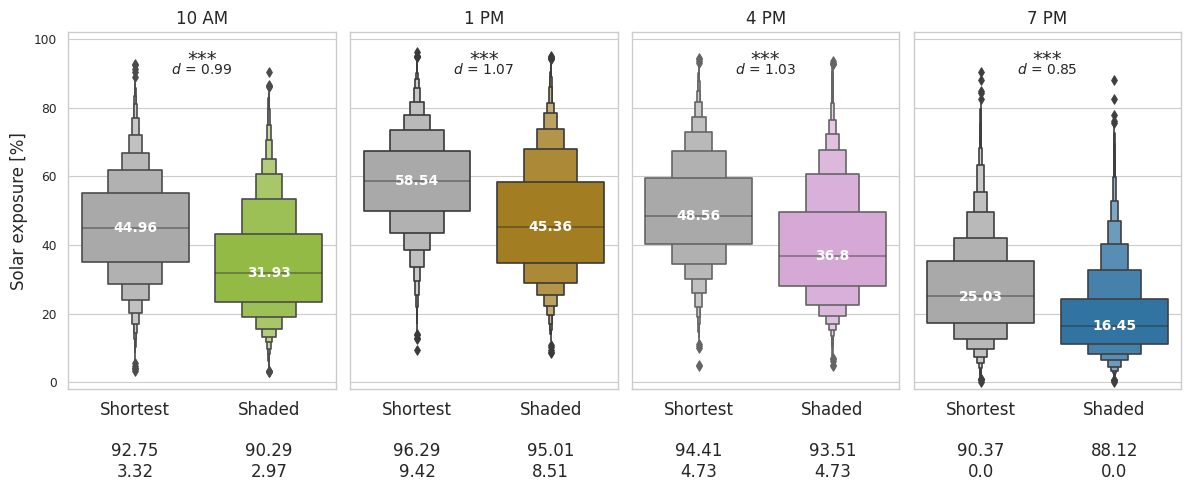

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 5), sharey=True)

for col, (tod, ax) in enumerate(zip(tod_list, axes)):
    dfex = df[df[f'sol_expo_{tod}'].notna()]
    g = sns.boxenplot(data=dfex, x='route_type', y=f'sol_expo_{tod}', palette=palette, ax=ax)
    g.set_xlabel('')
    g.set_ylabel('Solar exposure [%]', fontsize=12) if col == 0 else g.set_ylabel('')
    g.set_ylim(-2, 102)
    g.set_title(tod_format(tod), fontsize=12)
    median_default = dfex[dfex['route_type'] == f'{default_type} route'][f'sol_expo_{tod}'].median()
    median_time = dfex[dfex['route_type'] == f'{optimized_type} route at {tod}'][f'sol_expo_{tod}'].median()
    max_default = dfex[dfex['route_type'] == f'{default_type} route'][f'sol_expo_{tod}'].max()
    max_time = dfex[dfex['route_type'] == f'{optimized_type} route at {tod}'][f'sol_expo_{tod}'].max()
    min_default = dfex[dfex['route_type'] == f'{default_type} route'][f'sol_expo_{tod}'].min()
    min_time = dfex[dfex['route_type'] == f'{optimized_type} route at {tod}'][f'sol_expo_{tod}'].min()
    g.text(0, median_default, f'{round(median_default, 2)}', ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    g.text(1, median_time, f'{round(median_time, 2)}', ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    g.set_xticklabels([f'{default_type.title()}\n\n{max_default}\n{min_default}', f'Shaded\n\n{max_time}\n{min_time}'], fontsize=12)

    obs_mean, p_value, sig_level, cohens_d = permutation_test(dfex, tod)
    g.text(0.5, 92.5, sig_level, ha='center', fontsize=14)
    g.text(0.5, 90, rf'$d$ = {cohens_d:.2f}', ha='center', fontsize=10)
    print(f'{tod}: obs_mean={obs_mean:.4f}, p_value={p_value:.4f}, significance={sig_level}, cohens_d={cohens_d:.4f}')

plt.tight_layout()
plt.savefig(out_dir / f'sol_expo.png', dpi=300, bbox_inches='tight')
plt.show()